In [0]:
import requests
from datetime import datetime, timedelta
import pandas as pd
import time

base_url = "https://wikimedia.org/api/rest_v1/metrics/pageviews/top"
dataframes_by_year = []
access_method = "desktop"
agent = "user"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36"
}
combined_df = pd.DataFrame()

for year in range(2016, 2023):
    for month in range(1, 13):
        year_month = f"{year}-{month:02d}"  # Format month with leading zero
        month_df = pd.DataFrame(columns=["Rank", "Article", "Views"])
        #month_df["Year_Month"] = year_month
        url = f"{base_url}/en.wikipedia/all-access/{year}/{month:02d}/all-days"
        response = requests.get(url,headers=headers)
        

        if response.status_code == 200:
            data = response.json()
            articles = data["items"][0]["articles"]
            # Filter and add the top articles with ranks 1-10
            top_articles = [article for article in articles if article["rank"] <= 10]
            
            # Add year-month information to each article
            for article in top_articles:
                article["YearMonth"] = year_month
            
            # Append the current month's top articles to the combined DataFrame
            combined_df = combined_df.append(top_articles, ignore_index=True)
        else:
            print(f"Request for {year_month} failed. Status code:", response.status_code)

        # Introduce a delay to avoid rate limiting
        time.sleep(2)  # Sleep for 2 seconds between requests

final_df = pd.DataFrame(combined_df)
print(final_df)


<command-1693032553632490>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(top_articles, ignore_index=True)
<command-1693032553632490>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(top_articles, ignore_index=True)
<command-1693032553632490>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(top_articles, ignore_index=True)
<command-1693032553632490>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(top_articles, ignore_index=True)
<command-1693032553632490>:36: FutureWarning: The frame.append method is

               article      views  rank YearMonth
0            Main_Page  553772047     1   2016-01
1       Special:Search   63231369     2   2016-01
2          David_Bowie   13921255     3   2016-01
3      Bruce_Kingsbury   10478487     4   2016-01
4         Special:Book    9619486     5   2016-01
..                 ...        ...   ...       ...
835     FIFA_World_Cup    9162518     6   2022-12
836      Kylian_Mbappé    8387843     7   2022-12
837       Jenna_Ortega    7184194     8   2022-12
838  Cristiano_Ronaldo    6285456     9   2022-12
839               Pelé    5900989    10   2022-12

[840 rows x 4 columns]


In [0]:
pip install textblob

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
import pandas as pd
import concurrent.futures
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Wikipedia API base URL
api_base_url = "https://en.wikipedia.org/w/api.php"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36"
}

# Get the content of the article
def get_article_content(article_title):
    params = {
        "format": "json",
        "action": "query",
        "prop": "extracts",
        "titles": article_title
    }
    
    response = requests.get(api_base_url, headers=headers, params=params)
    data = response.json()
    #print(data)
    
    page_id = list(data["query"]["pages"].keys())[0]
    #print('Page_id: '+page_id)
    content = data["query"]["pages"][page_id].get("extract", "")
    #print(content)
    
    return content

analyzer = SentimentIntensityAnalyzer()

# NLTK resources
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Data preprocessing
def clean_text(text):
    text = text.lower()  # Lowercasing
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
    tokens = word_tokenize(text)  # Tokenization
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]  # Lemmatization and remove stopwords
    cleaned_text = " ".join(tokens)
    return cleaned_text

# Function to perform sentiment analysis using the preprocessed text
def perform_sentiment_analysis(article_title):
    article_content = get_article_content(article_title)
    cleaned_content = clean_text(article_content)
    sentiment_scores = analyzer.polarity_scores(cleaned_content)
    compound_score = sentiment_scores["compound"]
    return compound_score

# Add sentiment scores to DataFrame
final_df["SentimentScore"] = final_df["article"].apply(perform_sentiment_analysis)

# Map sentiment scores to labels
def map_sentiment_to_label(sentiment_score):
    if sentiment_score < -0.1:
        return "Negative"
    elif sentiment_score > 0.1:
        return "Positive"
    else:
        return "Neutral"

# Add sentiment labels to DataFrame
final_df["SentimentLabel"] = final_df["SentimentScore"].apply(map_sentiment_to_label)

# Save the updated DataFrame
final_df.to_csv("final_df_with_sentiment_labels.csv", index=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


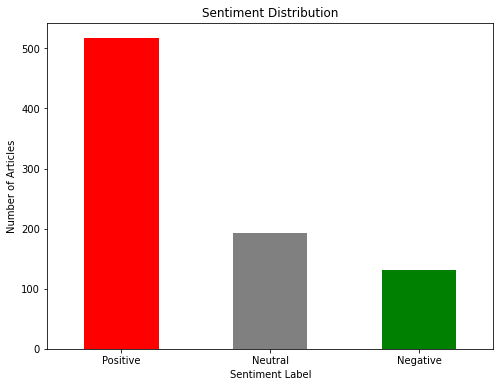

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# Count the occurrences of each sentiment label
sentiment_counts = final_df["SentimentLabel"].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind="bar", color=["red", "gray", "green"])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment Label")
plt.ylabel("Number of Articles")
plt.xticks(rotation=0)
plt.show()


<Figure size 720x432 with 0 Axes>

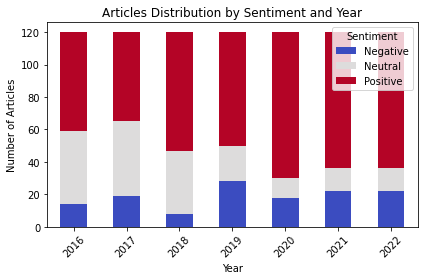

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract year from YearMonth column
final_df["Year"] = final_df["YearMonth"].str[:4]

# Group articles by year and sentiment label
articles_by_year_sentiment = final_df.groupby(["Year", "SentimentLabel"])["SentimentLabel"].count().unstack()

# Create a stacked bar plot
plt.figure(figsize=(10, 6))
articles_by_year_sentiment.plot(kind="bar", stacked=True, colormap="coolwarm")
plt.title("Articles Distribution by Sentiment and Year")
plt.xlabel("Year")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title="Sentiment", loc="upper right", labels=["Negative", "Neutral", "Positive"])
plt.show()


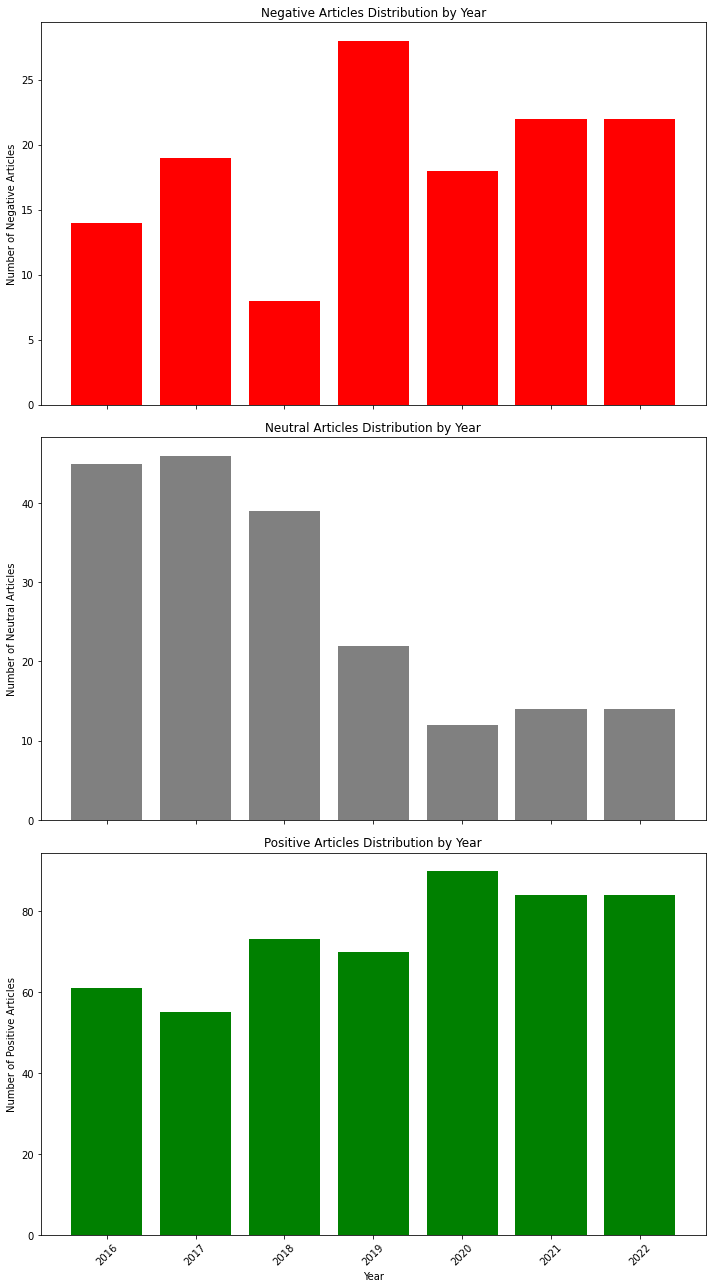

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract year from YearMonth column
final_df["Year"] = final_df["YearMonth"].str[:4]

# Group articles by year and sentiment label
articles_by_year_sentiment = final_df.groupby(["Year", "SentimentLabel"])["SentimentLabel"].count().unstack()

# Create separate subplots for each sentiment category
fig, axes = plt.subplots(3, 1, figsize=(10, 18), sharex=True)

# Plot for Negative Articles
axes[0].bar(articles_by_year_sentiment.index, articles_by_year_sentiment["Negative"], color="red")
axes[0].set_title("Negative Articles Distribution by Year")
axes[0].set_ylabel("Number of Negative Articles")

# Plot for Neutral Articles
axes[1].bar(articles_by_year_sentiment.index, articles_by_year_sentiment["Neutral"], color="gray")
axes[1].set_title("Neutral Articles Distribution by Year")
axes[1].set_ylabel("Number of Neutral Articles")

# Plot for Positive Articles
axes[2].bar(articles_by_year_sentiment.index, articles_by_year_sentiment["Positive"], color="green")
axes[2].set_title("Positive Articles Distribution by Year")
axes[2].set_ylabel("Number of Positive Articles")

# Setting a common x-label and rotating the x-axis ticks
plt.xlabel("Year")
for ax in axes:
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()
